# CS342 Final Project
### Dayou Ren; Spencer Petty
### dr37269; sap3758

In this project, we will be building and training an autoencoder architecture to generate images of CS professor. We are basically asking this question: "what does a neural network believe a CS professor should look like?"

# Imports

In [5]:
from PIL import Image
import cv2
import numpy as np
import torchvision
import pickle
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt


# Variational Autoencoder Classes

## Initial VAE

In [6]:
# From preprocessing
crop_size = (500, 500)
image_size = crop_size[0] * crop_size[1] * 3

class VAE(nn.Module):
    def __init__(self, latent_dims, hidden_nodes):
        super().__init__()
        self.encode1 = torch.nn.Linear(in_features = image_size, out_features = hidden_nodes)
        self.encode_mu = torch.nn.Linear(hidden_nodes, latent_dims)
        self.encode_sigma = torch.nn.Linear(hidden_nodes, latent_dims)
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0
        self.dims = latent_dims

        self.decode1 = torch.nn.Linear(latent_dims, hidden_nodes)
        self.decode2 = torch.nn.Linear(hidden_nodes, image_size)

    def forward(self, x):
        relu = torch.nn.ReLU()
        sigmoid = torch.nn.Sigmoid()
        # Encoding
        x = torch.flatten(x, start_dim = 1)
        x = self.encode1(x)
        x = relu(x)
        # Variational part of VAE
        mu = self.encode_mu(x)
        sigma = torch.exp(self.encode_sigma(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(torch.abs(sigma) + 1e-10) - 1/2).sum()

        #Decoding
        z = self.decode1(z)
        z = relu(z)
        z = self.decode2(z)
        x_hat = sigmoid(z)
        return torch.reshape(x_hat, (-1, 3, crop_size[0], crop_size[1]))
    
    def generate_face(self):
        mu = torch.rand(self.dims)
        sigma = torch.rand(self.dims)
        z = mu + sigma*self.N.sample(mu.shape)
        z = self.decode1(z)
        z = torch.nn.ReLU()(z)
        z = self.decode2(z)
        x_hat = torch.nn.Sigmoid()(z)
        plt.matshow(x_hat.squeeze().detach().reshape((crop_size[0], crop_size[1], -1)))
        return x_hat

## Convolutional VAE

In [7]:
class VAEConv(nn.Module):
    def __init__(self, latent_dims, hidden_nodes):
        super().__init__()
        # Encoding
        self.encode1  = nn.Conv2d(in_channels = 3, out_channels = 4, kernel_size = (32,32))
        self.encode2 = nn.MaxPool2d(kernel_size = (2,2), stride = 1)
        self.encode3  = nn.Linear(876096, hidden_nodes)                  
        self.encode_mu = torch.nn.Linear(hidden_nodes, latent_dims)
        self.encode_sigma = torch.nn.Linear(hidden_nodes, latent_dims)

        # Decoding
        self.decode1 = torch.nn.Linear(latent_dims, hidden_nodes)
        self.decode2 = torch.nn.Linear(hidden_nodes, image_size)

        # Other data
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0
        self.dims = latent_dims

    def forward(self, x):
        relu = torch.nn.ReLU()
        sigmoid = torch.nn.Sigmoid()
        # Encoding
        x = self.encode1(x)
        x = relu(self.encode2(x))
        x = torch.flatten(x, start_dim = 1, end_dim = -1)
        x = relu(self.encode3(x))
        # Variational part of VAE
        mu = self.encode_mu(x)
        sigma = torch.exp(self.encode_sigma(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(torch.abs(sigma) + 1e-10) - 1/2).sum()

        #Decoding
        z = self.decode1(z)
        z = relu(z)
        z = self.decode2(z)
        x_hat = sigmoid(z)
        return torch.reshape(x_hat, (-1, 3, crop_size[0], crop_size[1]))
    
    def generate_face(self):
        mu = torch.rand(self.dims)
        sigma = torch.rand(self.dims)
        z = mu + sigma*self.N.sample(mu.shape)
        z = self.decode1(z)
        z = torch.nn.ReLU()(z)
        z = self.decode2(z)
        x_hat = torch.nn.Sigmoid()(z)
        plt.matshow(x_hat.squeeze().detach().reshape((crop_size[0], crop_size[1], -1)))
        return x_hat

## Regularized Linear VAE

In [8]:
class VAEDropout(nn.Module):
    def __init__(self, latent_dims, hidden_nodes):
        super().__init__()
        self.encode1 = torch.nn.Linear(in_features = image_size, out_features = hidden_nodes)
        self.encode_mu = torch.nn.Linear(hidden_nodes, latent_dims)
        self.encode_sigma = torch.nn.Linear(hidden_nodes, latent_dims)
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0
        self.dims = latent_dims

        self.decode1 = torch.nn.Linear(latent_dims, hidden_nodes)
        self.decode2 = torch.nn.Linear(hidden_nodes, image_size)

    def forward(self, x):
        relu = torch.nn.ReLU()
        sigmoid = torch.nn.Sigmoid()
        # Encoding
        x = torch.flatten(x, start_dim = 1)
        x = self.encode1(x)
        x = torch.nn.Dropout(p = 0.5)(x)
        x = relu(x)
        # Variational part of VAE
        mu = self.encode_mu(x)
        sigma = torch.exp(self.encode_sigma(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(torch.abs(sigma) + 1e-10) - 1/2).sum()

        #Decoding
        z = self.decode1(z)
        z = torch.nn.Dropout(p = 0.5)(z)
        z = relu(z)
        z = self.decode2(z)
        z = torch.nn.Dropout(p = 0.5)(z)
        x_hat = sigmoid(z)
        return torch.reshape(x_hat, (-1, 3, crop_size[0], crop_size[1]))
    
    def generate_face(self):
        self.eval()
        mu = torch.rand(self.dims)
        sigma = torch.rand(self.dims)
        z = mu + sigma*self.N.sample(mu.shape)
        z = self.decode1(z)
        z = torch.nn.ReLU()(z)
        z = self.decode2(z)
        x_hat = torch.nn.Sigmoid()(z)
        plt.matshow(x_hat.squeeze().detach().reshape((crop_size[0], crop_size[1], -1)))
        return x_hat

# Test Functions

In [9]:
# Test the syntax and dimensionality of the model on one sample. Expect noise as output
def test_noise_generation(nodes = 64, gray = False):
    model = VAE(10, nodes)
    i = np.random.choice(13234)
    image_path = f'./lfwdatacolor/Faces/image_{i}.jpg'
    if gray:
        image_path = f'./lfwdatagray/Faces/image_{i}.jpg'
    imgnp = cv2.imread(image_path)
    imgnp = cv2.cvtColor(imgnp, cv2.COLOR_BGR2RGB)
    img = torch.reshape(torch.tensor(imgnp, dtype = torch.float32), (1, -1, crop_size[0], crop_size[1]))
    out = model(img)
    plt.imshow(imgnp)
    plt.matshow(out.squeeze().detach().reshape((crop_size[0], crop_size[1], -1)))

In [10]:
def compare_outputs(model, pretrain = True, gray = False):
    image_path = None
    if pretrain:
        i = np.random.choice(13234)
        image_path = f'./lfwdatacolor/Faces/image_{i}.jpg'
        if gray:
            image_path = f'./lfwdatagray/Faces/image_{i}.jpg'
    else:
        i = np.random.choice(97)
        image_path = f'./profdatacolor/Faces/image_{i}.jpg'
        if gray:
            image_path = f'./profdatagray/Faces/image_{i}.jpg'
    imgnp = cv2.imread(image_path)
    imgnp = cv2.cvtColor(imgnp, cv2.COLOR_BGR2RGB)
    img = torch.reshape(torch.tensor(imgnp, dtype = torch.float32), (1, -1, crop_size[0], crop_size[1]))
    out = model(img)
    plt.imshow(imgnp)
    plt.matshow(out.squeeze().detach().reshape((crop_size[0], crop_size[1], -1)))

In [11]:
def save_model(model, name = 'model.pkl'):
    pickle.dump(model, open(name, 'wb'))

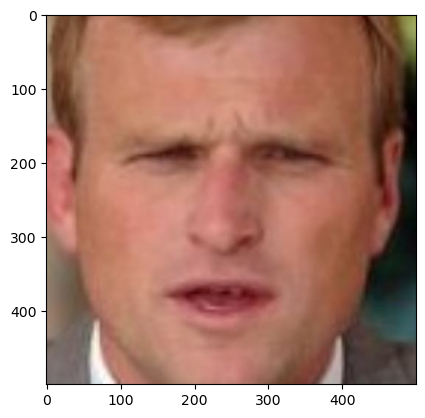

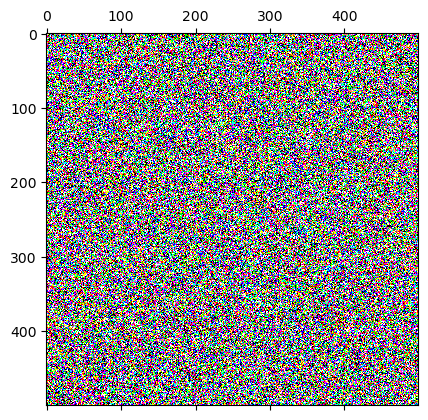

In [15]:
test_noise_generation()

# Train Function

In [13]:
# Doing in-place allows easier saving via pickle
def train_vae(model, dataloader, nepochs=100, inter_epoch  = True, regularize = False):
    model.train()
    optimizer = None
    if regularize:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay = 1e-2)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(nepochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            optimizer.zero_grad()
            x_hat = model(data)
            term1 = ((data - x_hat)**2).mean()
            term2 = model.kl
            loss = term1 + 1e-5*term2  
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
            if inter_epoch and batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader),
                    loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(dataloader.dataset)))
                
            

# Training

**PLEASE NOTE**: This current state of the notebook shows results for the full training process for the regularized linear model. The convolutional model and normal linear model do *not* have their training shown in this version of the notebook! Our writeup has information on all the ways each model differed and their relevant results. If you'd like to see how the other two models were precisely trained, see the following commits in the repository:


Normal linear model: ` 7e49f61`

Convolutional model: `2cd7f90`

In [14]:
nepochs_pre = 1     # Just demonstrating how the model will output nans
nepochs_main = 64    # Just demonstrating how the model will output nans
pretrainset = torchvision.datasets.ImageFolder('./lfwdatacolor', transform=torchvision.transforms.ToTensor())
pretrainloader = torch.utils.data.DataLoader(pretrainset, batch_size=64, shuffle=True)
linmodel = VAEConv(10,64)
train_vae(linmodel, pretrainloader, nepochs = nepochs_pre, regularize=False)
print(f'After {nepochs_pre}  epochs of pretraining')
compare_outputs(linmodel)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './cropped_lfw'

In [ ]:
trainset  = torchvision.datasets.ImageFolder('./profdatacolor', transform = torchvision.transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle=True)
train_vae(linmodel, trainloader, nepochs = nepochs_main, inter_epoch=False, regularize=False)

====> Epoch: 0 Average loss: nan
====> Epoch: 1 Average loss: nan
====> Epoch: 2 Average loss: nan


# Model Evaluation

In [ ]:
def compare_and_gen(model):
    compare_outputs(model, pretrain = False)
    model.generate_face()

## Regularized Linear Model

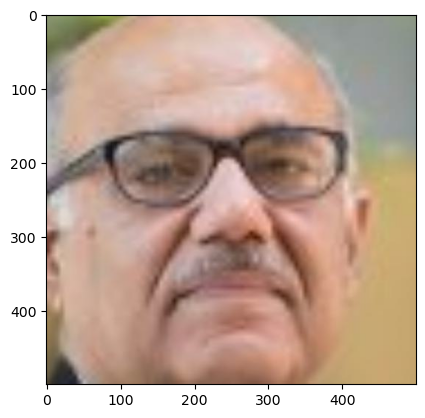

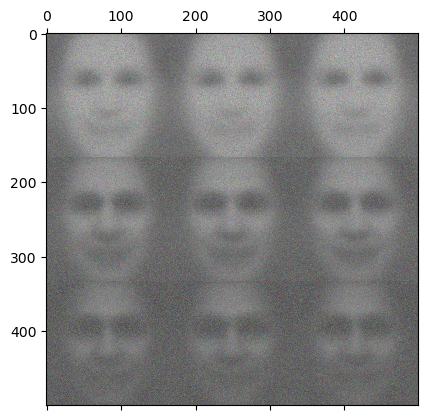

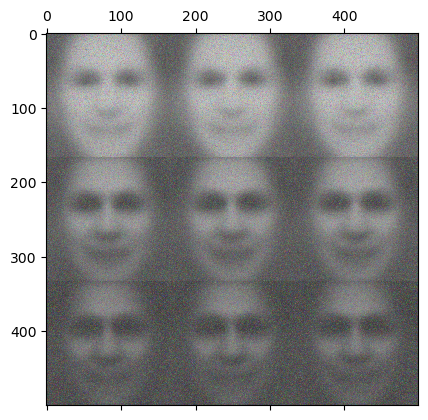

In [ ]:
compare_and_gen(linmodel)

## Convolutional Model

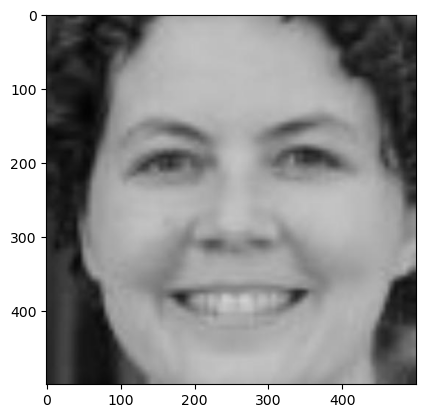

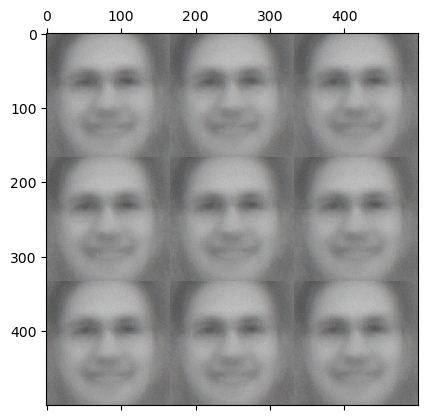

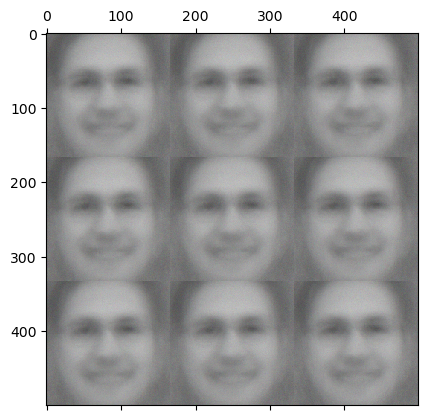

In [ ]:
old = pickle.load(open("./convmodel.pkl", "rb"))
convmodel = VAEConv(10, 64)
convmodel.load_state_dict(old.state_dict()) # Function must've change, must reinitialize and transfer weights
compare_and_gen(convmodel)

## Normal Linear Model

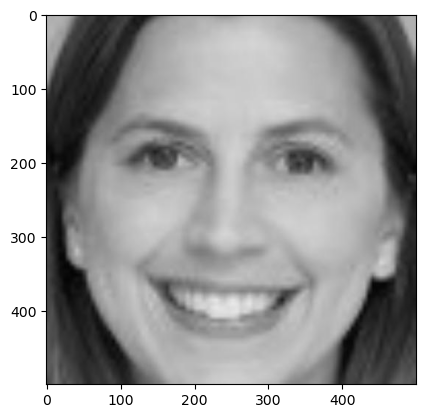

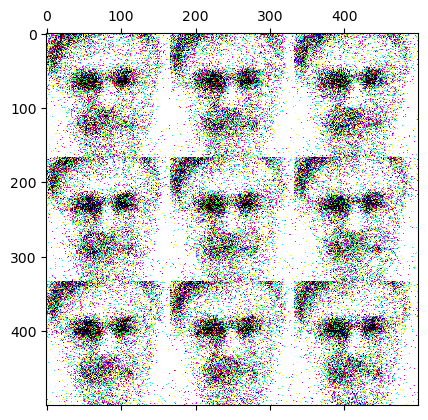

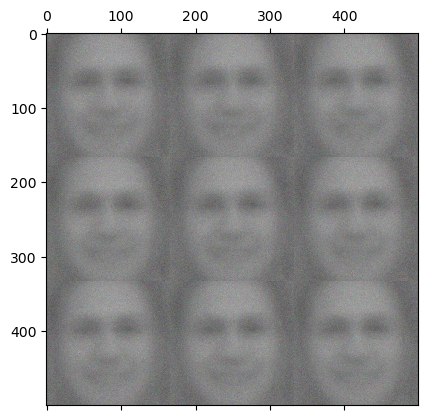

In [ ]:
normmodel = pickle.load(open("./model.pkl", "rb"))
compare_and_gen(normmodel)